# 28: MATRICES DE CONFUSIÓN Y CURVAS ROC

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import linear_model
from IPython.display import display, Math
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Creación del modelo de regresión logística

In [3]:
data = pd.read_csv('../../Recursos_curso/datasets/bank/bank.csv', sep = ';')

variables_categoricas = ["job", "marital", "education", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

clean_data = data

for i in variables_categoricas:
    new_name = 'new_' + i
    new_dummy = pd.get_dummies(data[i], prefix = new_name)
    new_data = clean_data.join(new_dummy)
    clean_data = new_data

new_categories = clean_data.columns.values.tolist()
variables_no_categoricas = [i for i in new_categories if i not in variables_categoricas] 
variables_no_categoricas.remove('default')

new_dataframe = clean_data[variables_no_categoricas]

observaciones = ['y']
candidatos = new_dataframe.columns.values.tolist()
candidatos.remove('y')

numero_parametros = 12

parametros = RFE(LogisticRegression(), n_features_to_select = numero_parametros).fit(new_dataframe[candidatos], 
                                                                                     new_dataframe[observaciones].values.ravel())  

resultado_decision = list(zip(candidatos, parametros.support_, parametros.ranking_))

parametros_importantes = []
for i in range(len(resultado_decision)):
    if resultado_decision[i][1] == True:
        parametros_importantes.append(resultado_decision[i][0])

x_valores = new_dataframe[parametros_importantes].astype(float)
y_valores = new_dataframe['y']
for i in range(len(y_valores)):
    y_valores[i] = np.where(y_valores[i] == 'no', False, True)
    
y_valores = y_valores.astype(float)

x_entreno, x_test, y_entreno, y_test = train_test_split(x_valores, y_valores, test_size = 0.25, random_state = 0) 

logistic_model = linear_model.LogisticRegression().fit(x_entreno, y_entreno)

C:\Users\Usuario\anaconda3\envs\curso_machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Usuario\anaconda3\envs\curso_machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

### Construcción de la matriz de confusión

La matriz de confusión se crea a partir de los falsos positivos, los falsos negativos y los resultados correctos. Los resultados correctos se producen cuando tanto la predicción como la observación coinciden.

- Falsos Positivos: Predicción POSITIVA cuando la observación es NEGATIVA
- Falsos Negativos: Predicción NEGATIVA cuando la observación es POSITIVA

In [6]:
# Obtener la predicción condicionada a un threshold previamente fijado

threshold = 0.1

prediccion = logistic_model.predict_proba(x_test) # devuelve una matriz de 2 columnas. La segunda fila es la pronanilidad de EXITO
probabilidad_exito = prediccion[:, 1] # nos quedamos exlusivamente con la probailidad de exito
dataframe_prediccion = pd.DataFrame(probabilidad_exito) # crea un dataframe
dataframe_prediccion['Predicción'] = np.where(dataframe_prediccion[0] >= threshold, 1, 0) # decide el exito en función del threshold
dataframe_prediccion['Observación'] = list(y_test)

In [7]:
dataframe_prediccion.head(15)

,0,Predicción,Observación
0,0.063090,0,0.0
1,0.117490,1,0.0
2,0.078957,0,0.0
3,0.058294,0,0.0
4,0.064172,0,0.0
5,0.026048,0,0.0
6,0.021606,0,0.0
7,0.085457,0,0.0
8,0.065531,0,0.0
9,0.068844,0,0.0


In [8]:
# Constuir la matriz de confusión

matriz_confusion = pd.crosstab(dataframe_prediccion.Predicción, dataframe_prediccion.Observación)
matriz_confusion

Observación,0.0,1.0
Predicción,,
0,705,38
1,224,63


In [11]:
# Definir los falsos positivos, falsos negativos y resultados correctos

falso_negativo = matriz_confusion[1][0]
falso_positivo = matriz_confusion[0][1]
autentico_negativo = matriz_confusion[0][0]
autentico_positivo = matriz_confusion[1][1]

In [12]:
print(f'Falsos Positivos: {falso_positivo}.')
print(f'Falsos Negativos: {falso_negativo}.')
print(f'Autenticos Positivos: {autentico_positivo}.')
print(f'Autenticos Negativos: {autentico_negativo}.')

Falsos Positivos: 224.
Falsos Negativos: 38.
Autenticos Positivos: 63.
Autenticos Negativos: 705.


In [14]:
# Calcular la sensibilidad y la especificidad

sensibilidad = autentico_positivo / (autentico_positivo + falso_negativo)
especificidad = 1 - (autentico_negativo / (autentico_negativo + falso_positivo))

In [15]:
print(f'Sensibilidad: {sensibilidad}.')
print(f'Especificidad: {especificidad}.')

Sensibilidad: 0.6237623762376238.
Especificidad: 0.2411194833153929.


### Curvas ROC

Para calcular la curva ROC hay que crear un vector con diferentes thresholds para calcular la especificidad y la sensibilidad del modelo en función de cada threshold. Entonces, lo que hay que hacer es hacer un plot de la especificadad contra la sensibilidad

In [19]:
# Cosntruimos los vectores de las sensibilidades y de las especifidades

thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]
sensibilidades = [1] # comenzamos el vector en 1
especificidades = [1] # comenzamos el vector en 1

for i in thresholds:
    dataframe_prediccion["Predicción"] = np.where(dataframe_prediccion[0] >= i, 1, 0)
    dataframe_prediccion["Observación"] = list(y_test)

    confusion_matrix = pd.crosstab(dataframe_prediccion.Predicción, dataframe_prediccion.Observación)
    TN = confusion_matrix[0][0]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    
    sensibilidad_i = TP / (TP + FN)
    sensibilidades.append(sensibilidad_i)
    especificidad_i = 1 - TN / (TN + FP)
    especificidades.append(especificidad_i)

sensibilidades.append(0)
especificidades.append(0)

In [20]:
sensibilidades

[1,
 0.9603960396039604,
 0.8712871287128713,
 0.6633663366336634,
 0.6237623762376238,
 0.594059405940594,
 0.5544554455445545,
 0.5247524752475248,
 0.5148514851485149,
 0.44554455445544555,
 0.3564356435643564,
 0.2079207920792079,
 0.15841584158415842,
 0]

In [21]:
especificidades

[1,
 0.7890204520990312,
 0.6490850376749193,
 0.28417653390742736,
 0.2411194833153929,
 0.1733046286329386,
 0.13885898815931108,
 0.1259418729817008,
 0.12271259418729819,
 0.07750269106566199,
 0.046286329386437064,
 0.016146393972012896,
 0.013993541442411161,
 0]

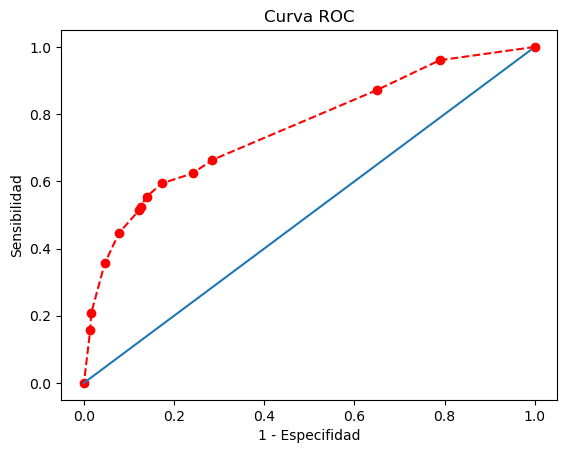

In [25]:
# Construir la curva ROC

plt.plot(especificidades, sensibilidades, marker = "o", linestyle = "--", color = "r")
x = [i * 0.01 for i in range(100)]
y = [i * 0.01 for i in range(100)]
plt.plot(x, y)
plt.xlabel("1 - Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")
%matplotlib inline